开始 MC 分析 (距离拒绝采样 + 速度各向同性采样)，共 7 颗源...


[1/7] J1041-1942   Age= 23.3 | Kick: 334 ± 332 km/s


[2/7] J1115+5030   Age= 10.5 | Kick: 401 ± 370 km/s


[3/7] J2326+6113   Age= 10.5 | Kick: 459 ± 404 km/s


[4/7] J1321+8323   Age= 18.0 | Kick: 510 ± 468 km/s


[5/7] J0152-1637   Age= 10.1 | Kick: 752 ± 675 km/s


[6/7] J1543-0620   Age= 12.9 | Kick: 452 ± 359 km/s


[7/7] J1840+5640   Age= 17.5 | Kick: 442 ± 398 km/s

分析完成！
生成的有效数据点总数: 7000


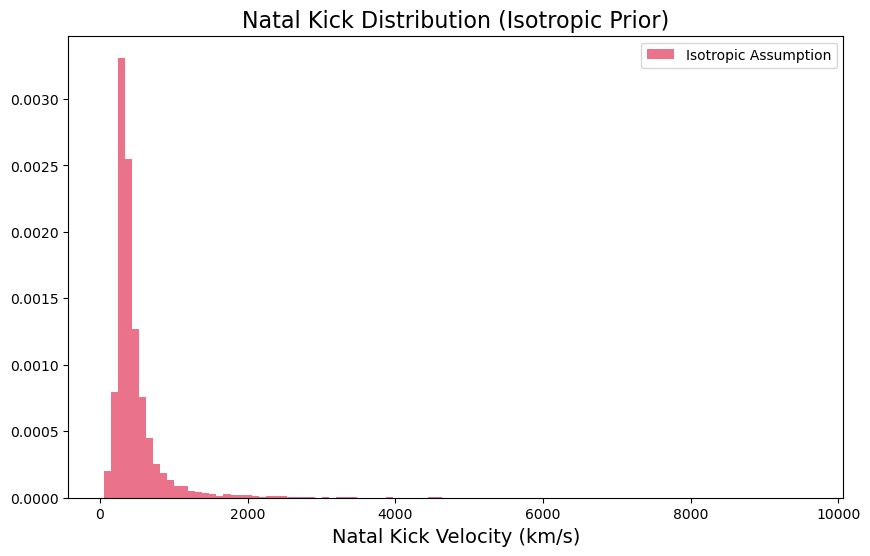

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, vcirc
from galpy.util import conversion
import astropy.units as u

# ==========================================
# 1. 物理环境配置与辅助函数
# ==========================================
RO_KPC = 8.12
VO_KMS = 220.0
POT = MWPotential2014
N_SAMPLES = 1000  # 每个源的样本数
V_MAX_CAP = 10000.0 # 速度上限

def sample_dist(center, err_plus, err_minus, n_needed, oversample=3):
    """ 拒绝采样生成正距离 (保持你原有的逻辑不变) """
    valid_samples = np.array([])
    while len(valid_samples) < n_needed:
        n_batch = (n_needed - len(valid_samples)) * oversample
        n_batch = max(n_batch, 100)
        upper = truncnorm.rvs(0, np.inf, loc=center, scale=err_plus, size=n_batch // 2)
        lower = truncnorm.rvs(-np.inf, 0, loc=center, scale=err_minus, size=n_batch - (n_batch // 2))
        batch = np.concatenate((upper, lower))
        good_batch = batch[batch > 0]
        valid_samples = np.concatenate((valid_samples, good_batch))
    result = valid_samples[:n_needed]
    np.random.shuffle(result)
    return result

def get_isotropic_vlos(v_trans_array, max_v=10000.0):
    """
    【核心新增函数】
    输入: 横向速度数组 v_trans
    输出: 满足各向同性且 v_3d < max_v 的视向速度 v_los
    逻辑: 并行拒绝采样
    """
    n = len(v_trans_array)
    v_los_result = np.zeros(n)
    
    # 标记哪些点还没有完成采样 (初始化为全部 True)
    unfinished_mask = np.ones(n, dtype=bool)
    
    # 当还有未完成的点时，继续循环
    while np.any(unfinished_mask):
        n_needed = np.sum(unfinished_mask)
        
        # 1. 对未完成的点生成 cos(theta) ~ U(-1, 1)
        cos_theta = np.random.uniform(-1.0, 1.0, n_needed)
        sin_theta = np.sqrt(1.0 - cos_theta**2)
        
        # 保护 sin_theta 防止除零 (极小值)
        sin_theta = np.maximum(sin_theta, 1e-10)
        
        # 2. 计算对应的 v_3d 和 v_los (只针对未完成的点)
        # 获取对应未完成点的 v_trans
        current_v_trans = v_trans_array[unfinished_mask]
        
        v_3d_trial = current_v_trans / sin_theta
        v_los_trial = v_3d_trial * cos_theta  # v_los = v_3d * cos(theta) = v_trans * cot(theta)
        
        # 3. 检查是否合格 (v_3d < max_v)
        valid = v_3d_trial < max_v
        
        # 4. 将合格的值填入结果数组
        # 注意：这里需要一些索引技巧
        # 获取 unfinished_mask 中为 True 的索引位置
        indices_needed = np.where(unfinished_mask)[0]
        # 在这些位置中，如果 valid 为 True，则填入数据
        indices_filled = indices_needed[valid]
        
        v_los_result[indices_filled] = v_los_trial[valid]
        
        # 5. 更新 mask，把已经填好的位置设为 False
        unfinished_mask[indices_filled] = False

    return v_los_result

def get_kick_velocity_at_birth(orbit_obj, age_myr):
    """ 计算出生时刻的 Kick 速度 (保持不变) """
    time_unit_gyr = conversion.time_in_Gyr(ro=RO_KPC, vo=VO_KMS)
    ts_galpy = np.array([0, -(age_myr / 1000.0) / time_unit_gyr])
    orbit_obj.integrate(ts_galpy, POT, method='dop853')
    
    # 获取出生时刻 (ts_galpy[-1]) 的坐标和速度
    x = orbit_obj.x(ts_galpy[-1], use_physical=True)
    y = orbit_obj.y(ts_galpy[-1], use_physical=True)
    vx = orbit_obj.vx(ts_galpy[-1], use_physical=True)
    vy = orbit_obj.vy(ts_galpy[-1], use_physical=True)
    vz = orbit_obj.vz(ts_galpy[-1], use_physical=True)
    
    R_cyl = np.sqrt(x**2 + y**2)
    vc_local = vcirc(POT, R_cyl/RO_KPC) * VO_KMS
    v_lsr_x = -vc_local * (y / R_cyl)
    v_lsr_y =  vc_local * (x / R_cyl)
    
    vk_x = vx - v_lsr_x
    vk_y = vy - v_lsr_y
    vk_z = vz 
    return np.sqrt(vk_x**2 + vk_y**2 + vk_z**2)

# ==========================================
# 2. 数据读取与处理
# ==========================================
try:
    df = pd.read_excel('/home/lz/galpy2.xlsx') # 确保路径正确
    df.fillna(0, inplace=True)
except Exception as e:
    print(f"无法读取文件: {e}")
    df = pd.DataFrame()

print(f"开始 MC 分析 (距离拒绝采样 + 速度各向同性采样)，共 {len(df)} 颗源...")

flat_data_for_bayes = [] 

for i, row in df.iterrows():
    try:
        name = row['Name']
        ra, dec = row['RA'], row['DEC']
        
        dist_cen = row['Dist']
        dist_upp = row['Dist_upp'] 
        dist_low = row['Dist_low'] 
        
        pmra_cen = row['pmra']
        pmra_err = row.get('pmra_err', row.get('pm_err', 0))
        pmdec_cen = row['pmdec']
        pmdec_err = row.get('pmdec_err', row.get('pmdec_error', 0))
        
        # 注意：这里不再需要 zeta 了
        raw_age = row['age']
        psr_age_myr = raw_age / 1e6 if raw_age > 1000 else raw_age
        
        # --- 1. 距离采样 ---
        sim_dist = sample_dist(dist_cen, dist_upp, dist_low, N_SAMPLES)
        
        # --- 2. 自行采样 ---
        sim_pmra = np.random.normal(pmra_cen, pmra_err, N_SAMPLES)
        sim_pmdec = np.random.normal(pmdec_cen, pmdec_err, N_SAMPLES)
        
        # --- 3. 速度推导 ---
        # 计算横向速度 v_trans
        sim_vt = 4.74047 * sim_dist * np.sqrt(sim_pmra**2 + sim_pmdec**2)
        
        # 【修改点】计算视向速度 v_rad (v_los)
        # 使用各向同性假设，且限制 V_3D < 10000
        sim_vr = get_isotropic_vlos(sim_vt, max_v=V_MAX_CAP)
            
        # --- 4. 建立轨道并回溯 ---
        # Galpy Orbit 输入顺序: [ra, dec, dist, pmra, pmdec, v_los]
        o_mc = Orbit(
            [ra * np.ones(N_SAMPLES), 
             dec * np.ones(N_SAMPLES), 
             sim_dist, 
             sim_pmra, 
             sim_pmdec, 
             sim_vr],       # 这里传入采样得到的视向速度
            radec=True, ro=RO_KPC, vo=VO_KMS
        )
        
        # 回溯
        birth_kicks = get_kick_velocity_at_birth(o_mc, psr_age_myr)
        
        # --- 5. 数据清洗 ---
        valid_indices = np.isfinite(birth_kicks)
        clean_kicks = birth_kicks[valid_indices]
        # 这里再次过滤一下最终结果，双重保险
        clean_kicks = clean_kicks[clean_kicks < V_MAX_CAP] 
        
        flat_data_for_bayes.extend(clean_kicks)
        
        print(f"[{i+1}/{len(df)}] {name:<12} Age={psr_age_myr:>5.1f} | Kick: {np.mean(clean_kicks):.0f} ± {np.std(clean_kicks):.0f} km/s")

    except Exception as e:
        print(f"❌ 处理 {row.get('Name', 'Unknown')} 时出错: {e}")
        # import traceback
        # traceback.print_exc() # 调试时可以打开

# ==========================================
# 3. 结果输出
# ==========================================
final_data = np.array(flat_data_for_bayes)

if len(final_data) > 0:
    print("\n分析完成！")
    print(f"生成的有效数据点总数: {len(final_data)}")
    np.savetxt("mc_birth_kicks_isotropic.txt", final_data)
    
    plt.figure(figsize=(10, 6))
    plt.hist(final_data, bins=100, color='crimson', alpha=0.6, density=True, label='Isotropic Assumption')
    plt.xlabel('Natal Kick Velocity (km/s)', fontsize=14)
    plt.title(f'Natal Kick Distribution (Isotropic Prior)', fontsize=16)
    plt.legend()
    plt.show()

In [2]:
print(len(final_data))

7000


正在读取文件: /home/lz/work/pulsar_kick_velocity/Pulsar_PA15_new_parallax.xlsx ...
成功加载 5 个脉冲星源。

开始生成样本 (每个源 1000 个, 假设各向同性)...
------------------------------------------------------------
Index  Name            Dist(est)  Mean V_3D   
------------------------------------------------------------
0      J0139+5814        2.70 kpc     498.0 km/s
1      J0534+2200        1.89 kpc     153.3 km/s
2      J0835-4510        0.29 kpc     117.8 km/s
3      J1932+1059        0.36 kpc     267.7 km/s
4      J2157+4017        3.57 kpc     444.4 km/s

处理完成
总样本数: 5000
预期样本数: 5000
数据已保存至: pulsar_isotropic_v3d_samples.txt


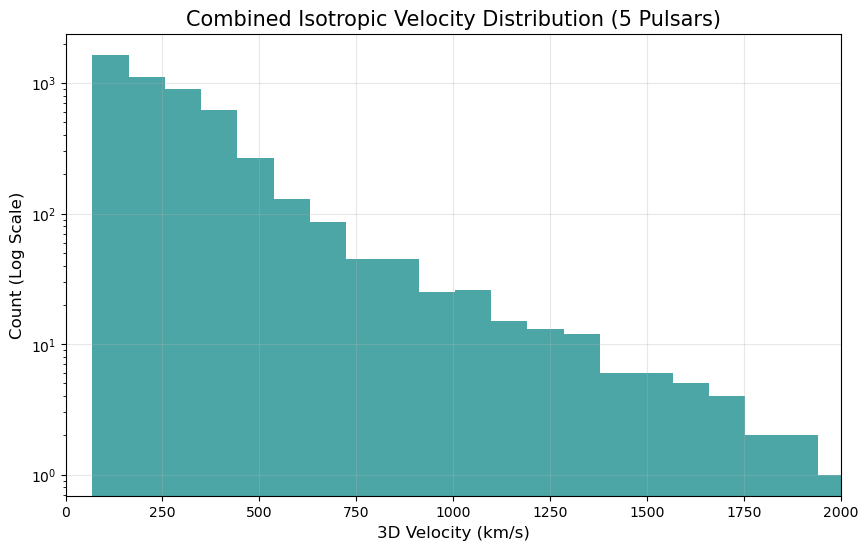

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 配置参数
# ==========================================
FILE_PATH = '/home/lz/work/pulsar_kick_velocity/Pulsar_PA15_new_parallax.xlsx'
N_SAMPLES = 1000       # 每个源生成的样本数
V_MAX_LIMIT = 10000.0  # 速度上限 (km/s)
# ==========================================
# 2. 读取数据
# ==========================================
print(f"正在读取文件: {FILE_PATH} ...")
try:
    data = pd.read_excel(FILE_PATH)
    # 提取列数据 (使用 .values 转换为 numpy 数组以提高计算速度)
    names = data.iloc[:, 0].values
    parallaxes = data.iloc[:, 1].values   # mas
    p_errs_up = data.iloc[:, 2].values    # mas (error +)
    p_errs_low = data.iloc[:, 3].values   # mas (error -)
    alphas = data.iloc[:, 4].values       # pmra
    alpha_errs = data.iloc[:, 5].values   # pmra err
    betas = data.iloc[:, 6].values        # pmdec
    beta_errs = data.iloc[:, 7].values    # pmdec err
    # zeta = data.iloc[:, 8].values       # 既然做各向同性，这列数据我们读取但不使用
    
    print(f"成功加载 {len(names)} 个脉冲星源。")

except Exception as e:
    print(f"读取文件出错: {e}")
    exit()

# ==========================================
# 3. 定义核心蒙特卡洛函数
# ==========================================
def run_isotropic_mc(parallax_val, p_up, p_low, 
                     pmra_val, pmra_e, 
                     pmdec_val, pmdec_e, 
                     n_target=1000, v_max=10000):
    """
    针对单个源生成 n_target 个符合各向同性分布的 3D 速度样本
    """
    valid_v3d = []
    
    # 每次生成一批数据，避免频繁循环。这里设为目标数量的 10 倍，防止被大量拒绝
    batch_size = n_target * 10
    
    while len(valid_v3d) < n_target:
        # 计算这就还需要多少个
        needed = n_target - len(valid_v3d)
        current_batch = max(batch_size, needed * 2) # 动态调整批次大小
        
        # --- A. 采样视差 (非对称误差处理) ---
        z_score = np.random.randn(current_batch)
        # 如果 z>0 用上误差，z<0 用下误差
        p_noise = np.where(z_score > 0, z_score * p_up, z_score * p_low)
        sim_p = parallax_val + p_noise
        
        # 物理过滤：视差必须 > 0.001 mas (即距离 < 1000 kpc，防止距离无穷大)
        mask_p = sim_p > 1e-3
        
        # --- B. 采样自行 (对称高斯) ---
        sim_alpha = np.random.normal(pmra_val, pmra_e, current_batch)
        sim_beta = np.random.normal(pmdec_val, pmdec_e, current_batch)
        
        # --- C. 计算 2D 横向速度 ---
        # V_trans = 4.74 * (1/p) * sqrt(mu_a^2 + mu_d^2)
        # 先只计算 valid 的视差对应的部分，防止除零警告
        sim_dist = np.zeros_like(sim_p)
        sim_dist[mask_p] = 1.0 / sim_p[mask_p]
        
        sim_vtrans = 4.74 * sim_dist * np.sqrt(sim_alpha**2 + sim_beta**2)
        
        # --- D. 采样各向同性角度 (Isotropy) ---
        # cos(theta) 在 [-1, 1] 均匀分布
        cos_theta = np.random.uniform(-1.0, 1.0, current_batch)
        sin_theta = np.sqrt(1.0 - cos_theta**2)
        
        # 保护 sin_theta 防止极小值导致速度爆炸
        sin_theta = np.maximum(sin_theta, 1e-5)
        
        # --- E. 计算 3D 速度 ---
        sim_v3d = sim_vtrans / sin_theta
        
        # --- F. 综合筛选 ---
        # 1. 视差有效 (mask_p)
        # 2. 速度 < v_max
        final_mask = mask_p & (sim_v3d < v_max)
        
        # 将合格的数据加入列表
        valid_v3d.extend(sim_v3d[final_mask])
    
    # 截取前 n_target 个返回
    return np.array(valid_v3d[:n_target])

# ==========================================
# 4. 主程序：循环处理每个源并拼接
# ==========================================
flat_v3d_samples = []  # 存放所有的速度样本 (N * 1000)
flat_names_ref = []    # 存放对应的名字 (方便后续查阅)

print(f"\n开始生成样本 (每个源 {N_SAMPLES} 个, 假设各向同性)...")
print("-" * 60)
print(f"{'Index':<6} {'Name':<15} {'Dist(est)':<10} {'Mean V_3D':<12}")
print("-" * 60)

for i, name in enumerate(names):
    # 提取当前源的参数
    p, p_up, p_low = parallaxes[i], p_errs_up[i], p_errs_low[i]
    pmra, pmra_e = alphas[i], alpha_errs[i]
    pmdec, pmdec_e = betas[i], beta_errs[i]
    
    # 运行 MC
    samples = run_isotropic_mc(p, p_up, p_low, 
                               pmra, pmra_e, 
                               pmdec, pmdec_e, 
                               n_target=N_SAMPLES, 
                               v_max=V_MAX_LIMIT)
    
    # 【关键步骤】将样本追加到大列表
    flat_v3d_samples.extend(samples)
    flat_names_ref.extend([name] * N_SAMPLES) # 记录ID
    
    # 打印进度
    est_dist = 1.0/p if p > 0 else 0
    print(f"{i:<6} {name:<15} {est_dist:>6.2f} kpc  {np.mean(samples):>8.1f} km/s")

# ==========================================
# 5. 保存与可视化
# ==========================================
# 转换为 numpy 数组
final_v3d_array = np.array(flat_v3d_samples)
final_names_array = np.array(flat_names_ref)

print("\n" + "="*30)
print("处理完成")
print(f"总样本数: {len(final_v3d_array)}")
print(f"预期样本数: {len(names) * N_SAMPLES}")
print("="*30)

# 保存为 txt 文件
# 格式：第一列是名字，第二列是模拟出的3D速度
output_file = 'pulsar_isotropic_v3d_samples.txt'
df_out = pd.DataFrame({'Name': final_names_array, 'V_3D': final_v3d_array})
df_out.to_csv(output_file, sep='\t', index=False)
print(f"数据已保存至: {output_file}")
# 简单画图检查一下总体分布
plt.figure(figsize=(10, 6))
plt.hist(final_v3d_array, bins=100, color='teal', alpha=0.7, log=True)
plt.xlim(0,2000)
plt.title(f'Combined Isotropic Velocity Distribution ({len(names)} Pulsars)', fontsize=15)
plt.xlabel('3D Velocity (km/s)', fontsize=12)
plt.ylabel('Count (Log Scale)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

正在读取文件: /home/lz/work/pulsar_kick_velocity/Pulsar_PA15_new.xlsx ...
成功加载 5 个脉冲星源。

开始生成样本 (输入为距离, 误差20%, 各向同性)...
------------------------------------------------------------
Index  Name            Dist(Input)  Mean V_3D   
------------------------------------------------------------
0      J0908-1739        0.81 kpc       296.6 km/s
1      J1328-4357        1.42 kpc       565.3 km/s
2      J1913-0440        4.04 kpc       465.6 km/s
3      J2257+5909        3.00 kpc       420.6 km/s
4      J1709-4429        2.60 kpc       230.3 km/s

处理完成 (Pulsar_PA15_new)
总样本数: 5000
数据已保存至: pulsar_new_isotropic_v3d_samples.txt


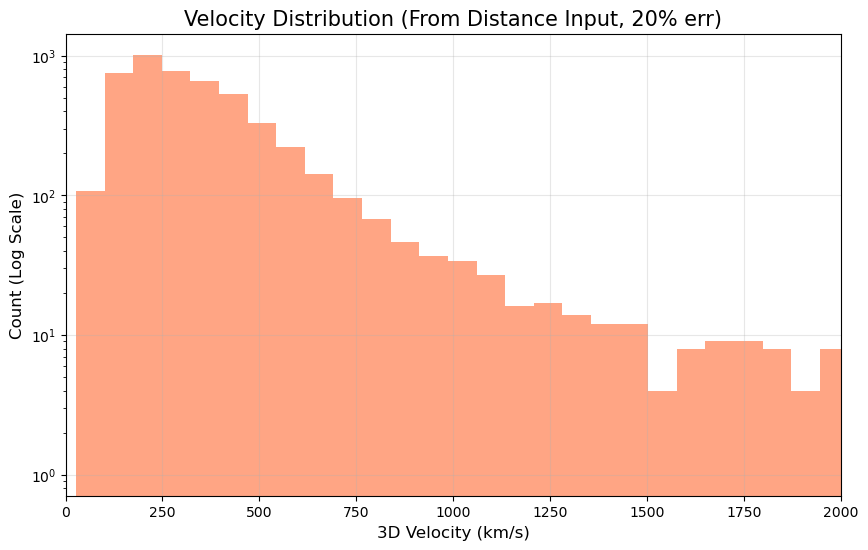

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 配置参数
# ==========================================
# 注意：这里改为了新的文件名
FILE_PATH = '/home/lz/work/pulsar_kick_velocity/Pulsar_PA15_new.xlsx'
N_SAMPLES = 1000       # 每个源生成的样本数
V_MAX_LIMIT = 10000.0  # 速度上限 (km/s)

# ==========================================
# 2. 读取数据
# ==========================================
print(f"正在读取文件: {FILE_PATH} ...")
try:
    data = pd.read_excel(FILE_PATH)
    # 提取列数据 (根据你提供的列顺序)
    names = data.iloc[:, 0].values
    distances = data.iloc[:, 1].values      # Distance (kpc)
    
    # 【修改点】根据你的描述，误差是对称的 20%
    dist_errs = 0.2 * distances             # Distance Error (kpc)
    
    alphas = data.iloc[:, 2].values         # pmra
    alpha_errs = data.iloc[:, 3].values     # pmra err
    betas = data.iloc[:, 4].values          # pmdec
    beta_errs = data.iloc[:, 5].values      # pmdec err
    
    # zeta = data.iloc[:, 6].values         # 既然做各向同性，不使用
    # zeta_err = data.iloc[:, 7].values     # 不使用
    
    print(f"成功加载 {len(names)} 个脉冲星源。")

except Exception as e:
    print(f"读取文件出错: {e}")
    exit()

# ==========================================
# 3. 定义核心蒙特卡洛函数 (适配距离版)
# ==========================================
def run_isotropic_mc_dist(dist_val, dist_e, 
                          pmra_val, pmra_e, 
                          pmdec_val, pmdec_e, 
                          n_target=1000, v_max=10000):
    """
    针对单个源生成 n_target 个符合各向同性分布的 3D 速度样本
    输入可以直接是距离和距离误差
    """
    valid_v3d = []
    
    # 每次生成一批数据
    batch_size = n_target * 10
    
    while len(valid_v3d) < n_target:
        needed = n_target - len(valid_v3d)
        current_batch = max(batch_size, needed * 2)
        
        # --- A. 采样距离 (直接正态采样) ---
        # 假设距离误差是对称高斯分布
        sim_dist = np.random.normal(dist_val, dist_e, current_batch)
        
        # 物理过滤：虽然大部分是正的，但为了防止 20% 误差采样出负值，必须过滤
        mask_d = sim_dist > 0
        
        # --- B. 采样自行 (对称高斯) ---
        sim_alpha = np.random.normal(pmra_val, pmra_e, current_batch)
        sim_beta = np.random.normal(pmdec_val, pmdec_e, current_batch)
        
        # --- C. 计算 2D 横向速度 ---
        # V_trans = 4.74 * d * sqrt(mu_a^2 + mu_d^2)
        sim_vtrans = 4.74 * sim_dist * np.sqrt(sim_alpha**2 + sim_beta**2)
        
        # --- D. 采样各向同性角度 (Isotropy) ---
        cos_theta = np.random.uniform(-1.0, 1.0, current_batch)
        sin_theta = np.sqrt(1.0 - cos_theta**2)
        sin_theta = np.maximum(sin_theta, 1e-5) # 保护除零
        
        # --- E. 计算 3D 速度 ---
        sim_v3d = sim_vtrans / sin_theta
        
        # --- F. 综合筛选 ---
        # 1. 距离 > 0 (mask_d)
        # 2. 速度 < v_max
        final_mask = mask_d & (sim_v3d < v_max)
        
        # 将合格的数据加入列表
        valid_v3d.extend(sim_v3d[final_mask])
    
    return np.array(valid_v3d[:n_target])

# ==========================================
# 4. 主程序：循环处理并拼接
# ==========================================
flat_v3d_samples_2 = []  # 存放所有的速度样本
flat_names_ref_2 = []    # 存放对应的名字

print(f"\n开始生成样本 (输入为距离, 误差20%, 各向同性)...")
print("-" * 60)
print(f"{'Index':<6} {'Name':<15} {'Dist(Input)':<12} {'Mean V_3D':<12}")
print("-" * 60)

for i, name in enumerate(names):
    # 提取参数
    d, d_err = distances[i], dist_errs[i]
    pmra, pmra_e = alphas[i], alpha_errs[i]
    pmdec, pmdec_e = betas[i], beta_errs[i]
    
    # 运行 MC (使用新的 distance 版本函数)
    samples = run_isotropic_mc_dist(d, d_err, 
                                    pmra, pmra_e, 
                                    pmdec, pmdec_e, 
                                    n_target=N_SAMPLES, 
                                    v_max=V_MAX_LIMIT)
    
    # 追加结果
    flat_v3d_samples_2.extend(samples)
    flat_names_ref_2.extend([name] * N_SAMPLES)
    
    print(f"{i:<6} {name:<15} {d:>6.2f} kpc    {np.mean(samples):>8.1f} km/s")

# ==========================================
# 5. 保存与可视化
# ==========================================
final_v3d_array_2 = np.array(flat_v3d_samples_2)
final_names_array_2 = np.array(flat_names_ref_2)

print("\n" + "="*30)
print("处理完成 (Pulsar_PA15_new)")
print(f"总样本数: {len(final_v3d_array_2)}")
print("="*30)

# 保存结果
output_file_2 = 'pulsar_new_isotropic_v3d_samples.txt'
df_out = pd.DataFrame({'Name': final_names_array_2, 'V_3D': final_v3d_array_2})
df_out.to_csv(output_file_2, sep='\t', index=False)
print(f"数据已保存至: {output_file_2}")

# 画图
plt.figure(figsize=(10, 6))
plt.hist(final_v3d_array_2, bins=100, color='coral', alpha=0.7, log=True)
plt.xlim(0, 2000)
plt.title(f'Velocity Distribution (From Distance Input, 20% err)', fontsize=15)
plt.xlabel('3D Velocity (km/s)', fontsize=12)
plt.ylabel('Count (Log Scale)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [14]:
data_process=np.concatenate([final_v3d_array,final_data])
np.savetxt('data_process.txt',data_process)

17000
9593.040623053248


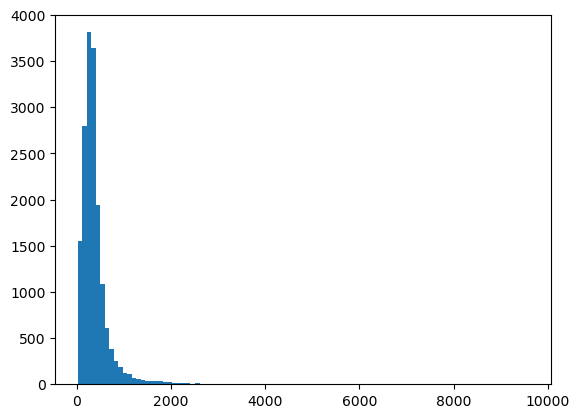

In [17]:
v_3D_17=np.concatenate([data_process,final_v3d_array_2])
print(len(v_3D_17))
plt.hist(v_3D_17,bins=100)
np.savetxt('v_3D_17.txt',v_3D_17)
print(max(v_3D_17))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sample_3d_velocity_asymmetric(v_cen, v_err_plus, v_err_minus, n_target=1000):
    """
    针对非对称误差 407 (+75, -57) 进行蒙特卡洛采样
    """
    samples_v3d = []
    
    # 每次生成一批，防止单次生成太少
    batch_size = n_target * 2 
    
    while len(samples_v3d) < n_target:
        # 1. 生成标准正态分布随机数 (mean=0, std=1)
        z = np.random.randn(batch_size)
        
        # 2. 根据 z 的正负，分别施加不同的误差缩放 (双片正态逻辑)
        # z > 0 时使用上限误差 v_err_plus
        # z < 0 时使用下限误差 v_err_minus
        noise = np.where(z > 0, z * v_err_plus, z * v_err_minus)
        # 3. 叠加到中心值
        trial_v3d = v_cen + noise
        # 4. 物理筛选：必须大于 0 且小于 10000 (拒绝采样)
        mask = (trial_v3d > 0) & (trial_v3d < 10000)
        valid_points = trial_v3d[mask]
        
        samples_v3d.extend(valid_points)
    # 截取前 n_target 个
    return np.array(samples_v3d[:n_target])

# ==========================================
# 执行采样
# ==========================================
v_3d_center = 407
err_plus = 75
err_minus = 57

v3d_samples_1 = sample_3d_velocity_asymmetric(v_3d_center, err_plus, err_minus, n_target=1000)


In [3]:
print(len(v3d_samples_1))

1000


In [7]:
samples_a=np.loadtxt('/home/lz/work/pulsar_kick_velocity/v_3D_17.txt')
samples_new=np.concatenate([v3d_samples_1,samples_a])
np.savetxt('samples_20_isotropy.txt',samples_new,fmt='%.6f')

In [3]:
import numpy as np
samples_new=np.loadtxt('samples_20_isotropy.txt')

In [4]:
import numpy as np
from scipy.special import erf
from scipy.stats import beta as beta_dist
from scipy.stats import truncnorm
from scipy.interpolate import interp1d
import bilby
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from bilby.core.prior import Uniform
from bilby.core.sampler import run_sampler
from bilby.core.prior import LogUniform
from bilby.hyper.likelihood import HyperparameterLikelihood
from scipy import interpolate
from scipy import integrate
import random
import argparse
import os
import glob
import warnings
warnings.filterwarnings("ignore")
#####################
samples_new=samples_new
outdir='hy_outdir'
data_exp=samples_new
import sys
#import utilizes
n_samples=1000
npool=300
NN=int(len(data_exp)/n_samples)
nlive=2000
mx=n_samples
#################################
data_df=list()
ns_m=abs(data_exp)
for i in range(NN):
    re=pd.DataFrame(ns_m[i*mx:(i+1)*mx],columns=['mu'])
    data_df.append(re)
samples = data_df

def run_prior(dataset):
    return 1



In [5]:
print(min(samples_new),max(samples_new))

26.605557 9593.040623


16:26 bilby INFO    : Running for label 'u_hype_45593', output will be saved to 'hy_outdir'


16:26 bilby INFO    : Analysis priors:
16:26 bilby INFO    : k=LogUniform(minimum=0.01, maximum=50, name='k', latex_label='$k$', unit=None, boundary=None)
16:26 bilby INFO    : theta=Uniform(minimum=1, maximum=400, name='theta', latex_label='$\\theta$(km/s)', unit=None, boundary=None)
16:26 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
16:26 bilby INFO    : Analysis likelihood noise evidence: 0
16:26 bilby INFO    : Single likelihood evaluation took 2.508e-04 s
16:26 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'rstate': None, 'queue_size': 300, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 'bootstrap': None, 'walks': 100, 'facc': 0.2, 'slices': None, 'ncdim': None, 'blob': False, 'sa

1it [00:00, ?it/s]

16:27 bilby INFO    : Written checkpoint file hy_outdir/u_hype_45593_resume.pickle
16:27 bilby INFO    : Starting to close worker pool.
16:28 bilby INFO    : Finished closing worker pool.


16:28 bilby INFO    : Rejection sampling nested samples to obtain 6341 posterior samples
16:28 bilby INFO    : Sampling time: 0:00:48.834261
16:28 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
16:28 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
16:28 bilby INFO    : Summary of results:
nsamples: 6341
ln_noise_evidence:  0.000
ln_evidence: -118.191 +/-  0.064
ln_bayes_factor: -118.191 +/-  0.064



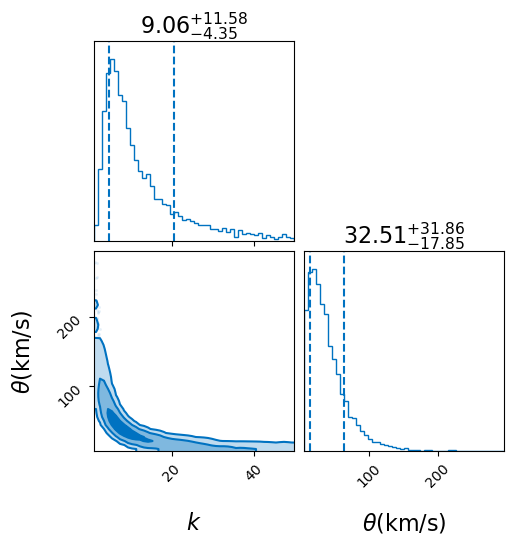

In [34]:
from scipy.special import beta
from scipy.special import gamma
def hyper_prior_gamma(dataset, k,theta):
    return (1 / (gamma(k)*theta**k)) * dataset['mu']**(k-1) *np.exp(-dataset['mu']/theta)

hp_priors_gamma = dict(k=LogUniform(0.01,50, 'k',r'$k$'),
                theta=Uniform(1, 400, 'theta',r'$\theta$(km/s)') )

hyper_prior_gamma=hyper_prior_gamma

hp_likelihood_gamma = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_gamma,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_gamma =hp_priors_gamma
# And run sampler
result_gamma = run_sampler(
    likelihood=hp_likelihood_gamma, priors=hp_priors_gamma, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_gamma.plot_corner(title_fmt='.1f')

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3009656/2237355552.py:4: SyntaxWarning: invalid escape sequence '\m'
  hp_priors_lognorm = dict(s_mu=Uniform(1, 10, 's_mu', '$\mu$'),
/tmp/ipykernel_3009656/2237355552.py:5: SyntaxWarning: invalid escape sequence '\s'
  s_sigma=Uniform(0.1, 10, 's_sigma', '$\sigma$') )
16:54 bilby INFO    : Running for label 'u_hype_34017', output will be saved to 'hy_outdir'
16:54 bilby INFO    : Analysis priors:
16:54 bilby INFO    : s_mu=Uniform(minimum=1, maximum=10, name='s_mu', latex_label='$\\mu$', unit=None, boundary=None)
16:54 bilby INFO    : s_sigma=Uniform(minimum=0.1, maximum=10, name='s_sigma', latex_label='$\\sigma$', unit=None, boundary=None)
16:54 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
16:54 bilby INFO    : Analys

1it [00:00, ?it/s]

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in

16:55 bilby INFO    : Rejection sampling nested samples to obtain 6149 posterior samples
16:55 bilby INFO    : Sampling time: 0:00:34.871851
16:55 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
16:55 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
16:55 bilby INFO    : Summary of results:
nsamples: 6149
ln_noise_evidence:  0.000
ln_evidence: -119.771 +/-  0.074
ln_bayes_factor: -119.771 +/-  0.074



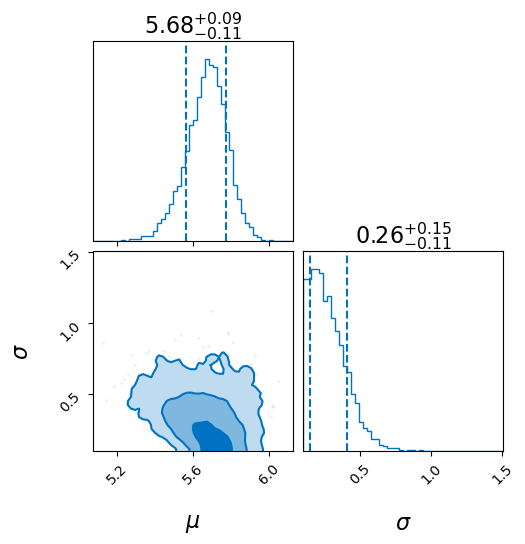

In [11]:
def hyper_prior_lognorm(dataset, s_mu, s_sigma):
    return np.exp(- (np.log(dataset['mu']) - s_mu)**2 / (2 * s_sigma**2)) /\
        (2 * np.pi * s_sigma**2)**0.5/(dataset['mu'])
hp_priors_lognorm = dict(s_mu=Uniform(1, 10, 's_mu', '$\mu$'),
                 s_sigma=Uniform(0.1, 10, 's_sigma', '$\sigma$') )

hyper_prior_lognorm=hyper_prior_lognorm
hp_likelihood_lognorm = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_lognorm,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_lognorm =hp_priors_lognorm

# And run sampler
result_lognorm = run_sampler(
    likelihood=hp_likelihood_lognorm, priors=hp_priors_lognorm, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_lognorm.plot_corner()

16:28 bilby INFO    : Running for label 'double_maxwell_hype_65858', output will be saved to 'hy_outdir'
16:28 bilby INFO    : Analysis priors:
16:28 bilby INFO    : sigma1=Uniform(minimum=10, maximum=2500, name='sigma1', latex_label='$\\sigma_1$(km/s)', unit=None, boundary=None)
16:28 bilby INFO    : sigma2=Uniform(minimum=10, maximum=2500, name='sigma2', latex_label='$\\sigma_2$(km/s)', unit=None, boundary=None)
16:28 bilby INFO    : alpha=Uniform(minimum=0.01, maximum=0.99, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None)
16:28 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
16:28 bilby INFO    : Analysis likelihood noise evidence: 0
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
16:28 bilby INFO    : Single likelihood evaluation took 7.027e-04 s
1

1it [00:00, ?it/s]

16:33 bilby INFO    : Written checkpoint file hy_outdir/double_maxwell_hype_65858_resume.pickle
16:33 bilby INFO    : Starting to close worker pool.
16:33 bilby INFO    : Finished closing worker pool.


16:33 bilby INFO    : Rejection sampling nested samples to obtain 5946 posterior samples
16:33 bilby INFO    : Sampling time: 0:04:22.941178
16:33 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
16:33 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
16:33 bilby INFO    : Summary of results:
nsamples: 5946
ln_noise_evidence:  0.000
ln_evidence: -119.017 +/-  0.062
ln_bayes_factor: -119.017 +/-  0.062



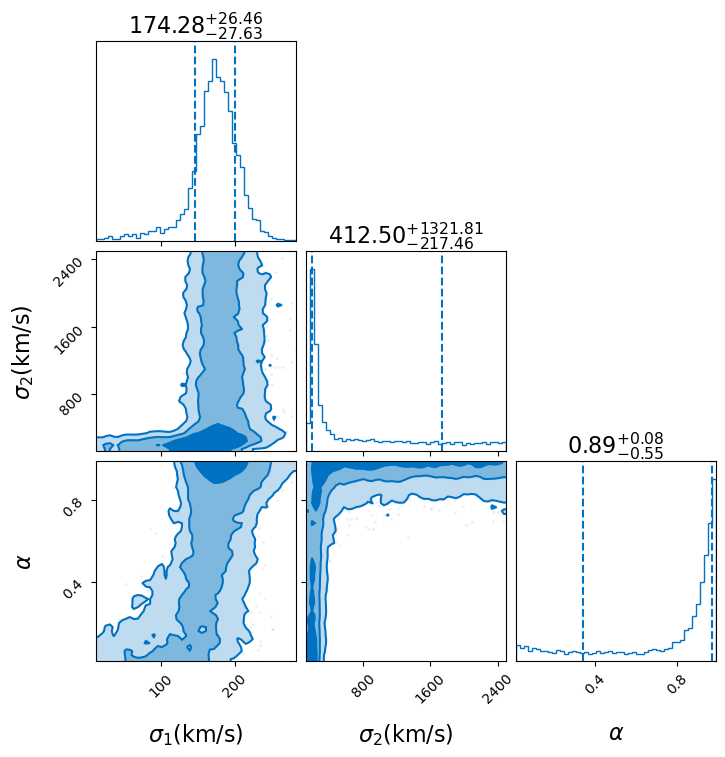

In [35]:
from scipy.stats import maxwell
def hyper_prior_double_maxwell(dataset,sigma1, sigma2, alpha):
    mup=10000
    mlo=1
    # 数据范围限制
    sigma_constraint = (mlo < sigma1) & (sigma1 < sigma2) & (sigma2 < mup)
    valid_range = (dataset['mu'] >= mlo) & (dataset['mu'] <= mup)
    
    # Maxwell PDF for the two components
    pdf1 = maxwell.pdf(dataset['mu'], scale=sigma1)
    pdf2 = maxwell.pdf(dataset['mu'], scale=sigma2)
    # Combined mixture PDF
    mixture_pdf = alpha * pdf1 + (1 - alpha) * pdf2
    # Apply range restriction
    log_likelihood = sigma_constraint*valid_range * mixture_pdf
    return log_likelihood

hp_priors_double_maxwell = dict(
    sigma1=Uniform(10, 2500, 'sigma1', r'$\sigma_1$(km/s)'),
    sigma2=Uniform(10, 2500, 'sigma2', r'$\sigma_2$(km/s)'),
    alpha=Uniform(0.01, 0.99, 'alpha', r'$\alpha$')
)

hyper_prior_double_maxwell = hyper_prior_double_maxwell

hp_likelihood_double_maxwell = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_double_maxwell,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_double_maxwell = hp_priors_double_maxwell
# 运行采样器
result_2M = run_sampler(
    likelihood=hp_likelihood_double_maxwell, priors=hp_priors_double_maxwell, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='double_maxwell_hype_{}'.format(np.random.randint(1, 88888)),
    verbose=True, clean=True, npool=npool)
# 绘制角图
result_2M.plot_corner()

16:33 bilby INFO    : Running for label 'maxwell_hype_65716', output will be saved to 'hy_outdir'
16:33 bilby INFO    : Analysis priors:
16:33 bilby INFO    : sigma=Uniform(minimum=10, maximum=2500, name='sigma', latex_label='$\\sigma$', unit=None, boundary=None)
16:33 bilby INFO    : mlo=Uniform(minimum=1, maximum=400, name='mlo', latex_label='$\\rm{v^{lo}}$', unit=None, boundary=None)
16:33 bilby INFO    : mup=Uniform(minimum=400, maximum=10000, name='mup', latex_label='$\\rm{v^{up}}$', unit=None, boundary=None)
16:33 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
16:33 bilby INFO    : Analysis likelihood noise evidence: 0
16:33 bilby INFO    : Single likelihood evaluation took 4.871e-04 s
16:33 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'rstate': None, 'queue_size': 300, 'pool': None, '

1it [00:00, ?it/s]

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in

16:34 bilby INFO    : Rejection sampling nested samples to obtain 4976 posterior samples
16:34 bilby INFO    : Sampling time: 0:00:33.052298
16:34 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
16:34 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
16:34 bilby INFO    : Summary of results:
nsamples: 4976
ln_noise_evidence:  0.000
ln_evidence: -118.630 +/-  0.062
ln_bayes_factor: -118.630 +/-  0.062



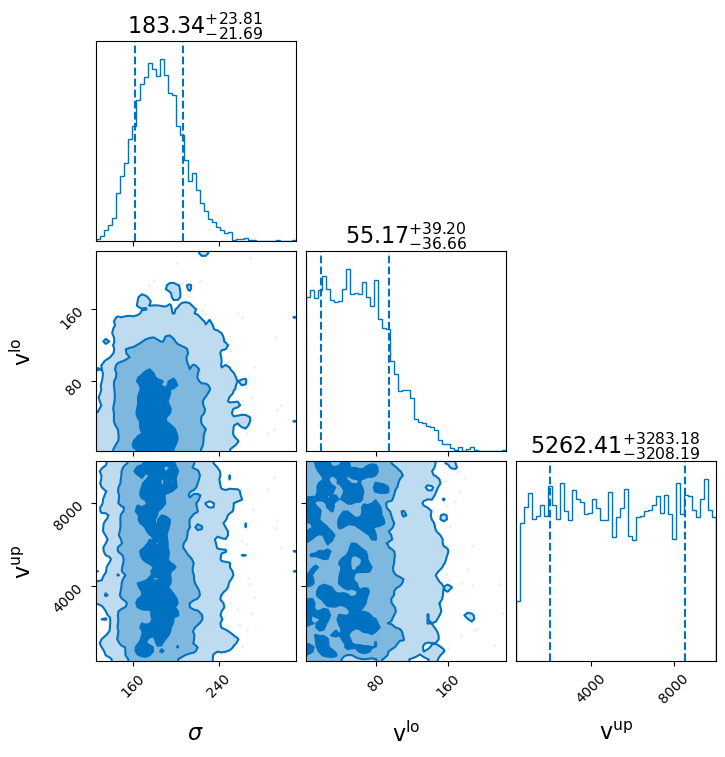

In [36]:
from scipy.stats import maxwell
from scipy.integrate import quad
def hyper_prior_maxwell(dataset,mlo,mup,sigma):
    log_likelihood = ((dataset['mu'] >= mlo) & (dataset['mu'] <= mup)) * maxwell.pdf(dataset['mu'],scale=sigma)
    return log_likelihood

hp_priors_maxwell = dict(sigma=Uniform(10, 2500, 'sigma', r'$\sigma$'),
                        mlo=Uniform(1,400,'mlo', r'$\rm{v^{lo}}$'),
                        mup=Uniform(400,10000,'mup', r'$\rm{v^{up}}$')
                        )

hyper_prior_maxwell = hyper_prior_maxwell
hp_likelihood_maxwell = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_maxwell,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_maxwell = hp_priors_maxwell
result_maxwell = run_sampler(
    likelihood=hp_likelihood_maxwell, priors=hp_priors_maxwell, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='maxwell_hype_{}'.format(np.random.randint(1, 88888)),
    verbose=True, clean=True, npool=npool)

result_maxwell.plot_corner()

15:14 bilby INFO    : Running for label 'u_hype_25550', output will be saved to 'hy_outdir'
15:14 bilby INFO    : Analysis priors:
15:14 bilby INFO    : mlo=Uniform(minimum=1, maximum=400, name='mlo', latex_label='$\\rm{v^l}$', unit=None, boundary=None)
15:14 bilby INFO    : mup=Uniform(minimum=400, maximum=10000, name='mup', latex_label='$\\rm{v^u}$', unit=None, boundary=None)
15:14 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
15:14 bilby INFO    : Analysis likelihood noise evidence: 0
15:14 bilby INFO    : Single likelihood evaluation took 1.375e-04 s
15:14 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'rstate': None, 'queue_size': 300, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': None, 

1it [00:00, ?it/s]

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in

15:15 bilby INFO    : Rejection sampling nested samples to obtain 6436 posterior samples
15:15 bilby INFO    : Sampling time: 0:00:29.323170
15:15 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
15:15 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
15:15 bilby INFO    : Summary of results:
nsamples: 6436
ln_noise_evidence:  0.000
ln_evidence: -118.335 +/-  0.065
ln_bayes_factor: -118.335 +/-  0.065



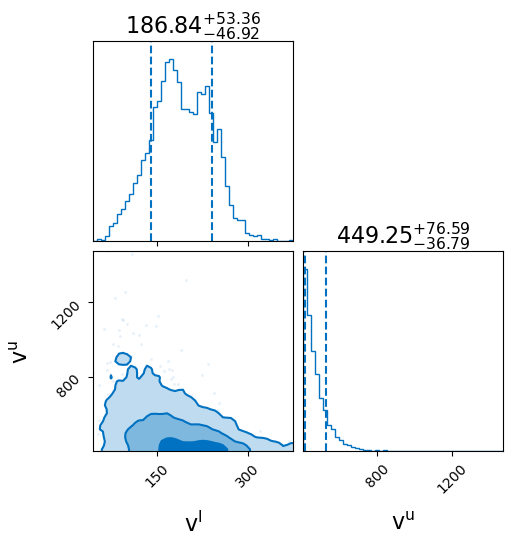

In [14]:
def hyper_prior_logu(dataset,mlo,mup):
    return (( dataset['mu'] >= mlo) & (dataset['mu'] <= mup))/( dataset['mu'] * np.log(mup / mlo) )

hp_priors_logu = dict(mlo=Uniform(1, 400, 'mlo',r'$\rm{v^l}$'),
                mup=Uniform(400, 10000, 'mup',r'$\rm{v^u}$'))
#end log-uniform

hyper_prior_logu=hyper_prior_logu

hp_likelihood_logu = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_logu,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_logu =hp_priors_logu

# And run sampler
result_logu = run_sampler(
    likelihood=hp_likelihood_logu, priors=hp_priors_logu, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_logu.plot_corner()

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1436124/2174928955.py:8: SyntaxWarning: invalid escape sequence '\m'
  hp_priors_G_fixed_max_min= dict(mu=Uniform(10, 4000, 's_mu', '$\mu$'),
/tmp/ipykernel_1436124/2174928955.py:9: SyntaxWarning: invalid escape sequence '\s'
  sigma=Uniform(10, 1500, 's_sigma', '$\sigma$'))
16:25 bilby INFO    : Running for label 'u_hype_25712', output will be saved to 'hy_outdir'
16:25 bilby INFO    : Analysis priors:
16:25 bilby INFO    : mu=Uniform(minimum=10, maximum=4000, name='s_mu', latex_label='$\\mu$', unit=None, boundary=None)
16:25 bilby INFO    : sigma=Uniform(minimum=10, maximum=1500, name='s_sigma', latex_label='$\\sigma$', unit=None, boundary=None)
16:25 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
16:25 bilby INFO    : 

1it [00:00, ?it/s]

16:26 bilby INFO    : Written checkpoint file hy_outdir/u_hype_25712_resume.pickle
16:26 bilby INFO    : Starting to close worker pool.
16:26 bilby INFO    : Finished closing worker pool.


16:26 bilby INFO    : Rejection sampling nested samples to obtain 5447 posterior samples
16:26 bilby INFO    : Sampling time: 0:00:32.390552
16:26 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
16:26 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
16:26 bilby INFO    : Summary of results:
nsamples: 5447
ln_noise_evidence:  0.000
ln_evidence: -118.823 +/-  0.071
ln_bayes_factor: -118.823 +/-  0.071



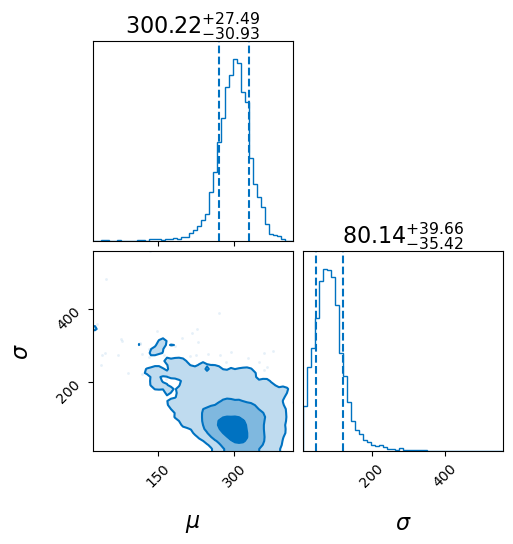

In [33]:
#begin Gaussian model with fixed upper and lower mass
def hyper_prior_G_fixed_max_min(dataset, mu, sigma):
    mup=10000
    mlo=1
    normalisingTerm = 0.5 * ( erf((mu-mlo)/(np.sqrt(2) * sigma)) -  erf((mu-mup)/(np.sqrt(2) * sigma)) )
    return ( ( dataset['mu'] >= mlo) & (dataset['mu'] <= mup))*((mu>mlo)&(mu<mup)) * (np.exp(- (dataset['mu'] - mu)**2 / (2 * sigma**2)) /\
        (2 * np.pi * sigma**2)**0.5) / normalisingTerm 
hp_priors_G_fixed_max_min= dict(mu=Uniform(10, 4000, 's_mu', '$\mu$'),
                 sigma=Uniform(10, 1500, 's_sigma', '$\sigma$'))
#end Gaussian with fixed upper and lower ma
#end Gaussian model 
hyper_prior_G=hyper_prior_G_fixed_max_min
hp_likelihood_G = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_G,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_G =hp_priors_G_fixed_max_min

# And run sampler
result_G = run_sampler(
    likelihood=hp_likelihood_G, priors=hp_priors_G, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_G.plot_corner()

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1436124/1786527747.py:9: SyntaxWarning: invalid escape sequence '\m'
  hp_priors_2G_fixed_max_min = dict(mu1=Uniform(10, 4000, 'mu1', '$\mu_1$'),
/tmp/ipykernel_1436124/1786527747.py:10: SyntaxWarning: invalid escape sequence '\s'
  sigma1=Uniform(10, 1500, 'sigma1', '$\sigma_1$'),
/tmp/ipykernel_1436124/1786527747.py:11: SyntaxWarning: invalid escape sequence '\m'
  mu2=Uniform(10, 4000, 'mu2', '$\mu_2$'),
/tmp/ipykernel_1436124/1786527747.py:12: SyntaxWarning: invalid escape sequence '\s'
  sigma2=Uniform(10, 1500, 'sigma2', '$\sigma_2$'),
15:17 bilby INFO    : Running f

1it [00:00, ?it/s]

15:30 bilby INFO    : Written checkpoint file hy_outdir/u_hype_19393_resume.pickle
15:42 bilby INFO    : Written checkpoint file hy_outdir/u_hype_19393_resume.pickle
15:42 bilby INFO    : Starting to close worker pool.
15:42 bilby INFO    : Finished closing worker pool.


15:42 bilby INFO    : Rejection sampling nested samples to obtain 7360 posterior samples
15:42 bilby INFO    : Sampling time: 0:24:59.376244
15:42 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
15:42 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
15:42 bilby INFO    : Summary of results:
nsamples: 7360
ln_noise_evidence:  0.000
ln_evidence: -120.799 +/-  0.074
ln_bayes_factor: -120.799 +/-  0.074



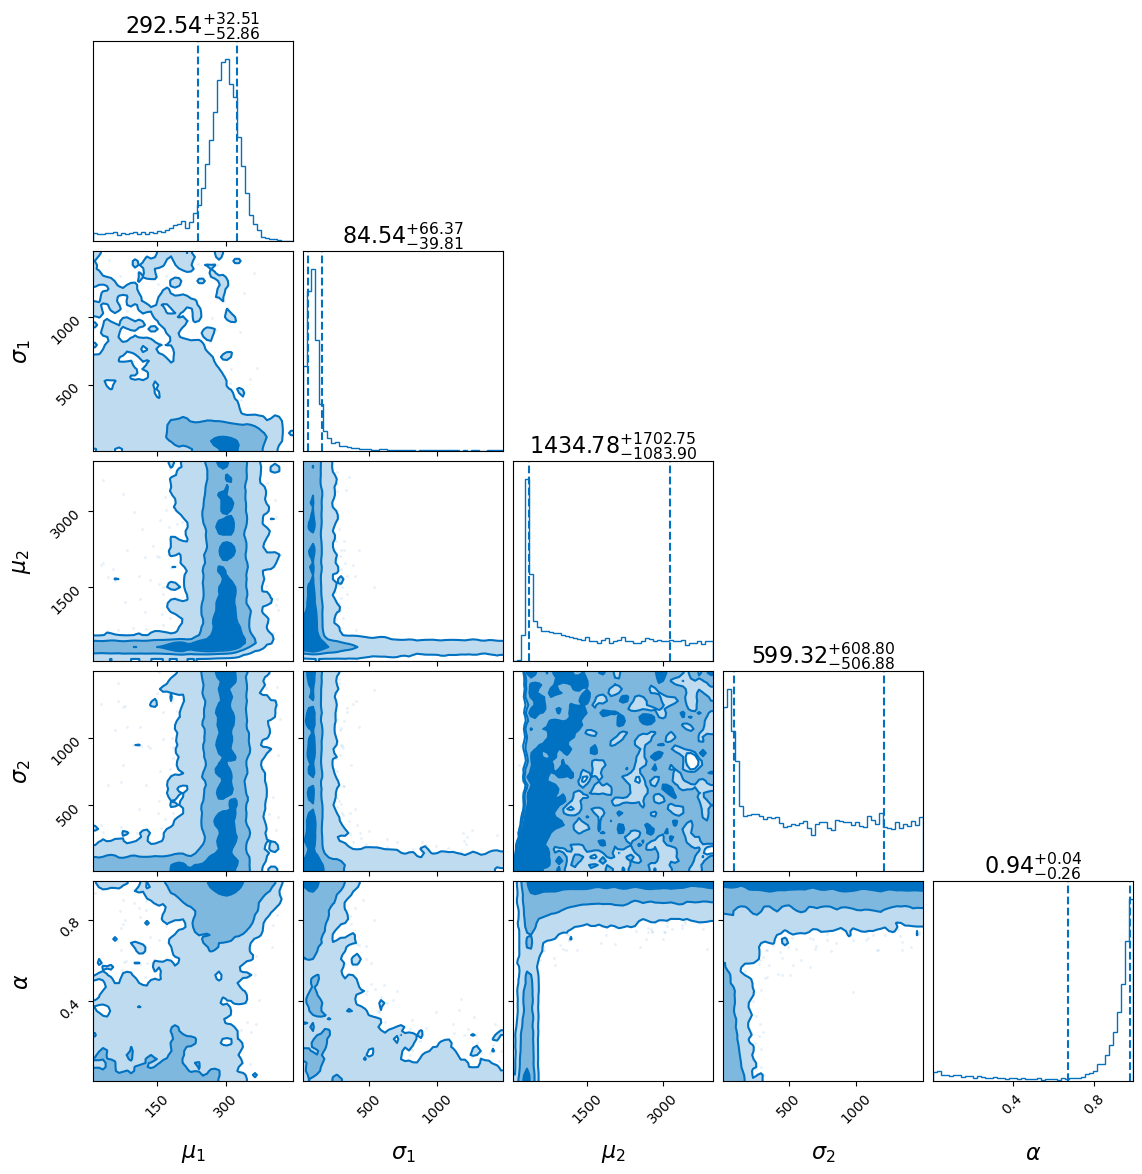

In [16]:
def hyper_prior_2G_fixed_max_min(dataset, mu1, sigma1,mu2,sigma2,alpha):
    mup=10000
    mlo=1
    normalisingTerm1 = 0.5 * ( erf((mu1-mlo)/(np.sqrt(2) * sigma1)) -  erf((mu1-mup)/(np.sqrt(2) * sigma1)) )
    normalisingTerm2 = 0.5 * ( erf((mu2-mlo)/(np.sqrt(2) * sigma2)) -  erf((mu2-mup)/(np.sqrt(2) * sigma2)) )
    return ((mu2 < mup ) & (mu1 > mlo) & (mu1 < mu2)  & ( dataset['mu'] >= mlo) & (dataset['mu'] <= mup)) *\
        ( (( alpha*(np.exp(- (dataset['mu'] - mu1)**2 / (2 * sigma1**2)) /(2 * np.pi * sigma1**2)**0.5)) /normalisingTerm1) +\
        (1-alpha)*( ((np.exp(- (dataset['mu'] - mu2)**2 / (2 * sigma2**2)) /(2 * np.pi * sigma2**2)**0.5) ) / normalisingTerm2) )
hp_priors_2G_fixed_max_min = dict(mu1=Uniform(10, 4000, 'mu1', '$\mu_1$'),
                 sigma1=Uniform(10, 1500, 'sigma1', '$\sigma_1$'),
                mu2=Uniform(10, 4000, 'mu2', '$\mu_2$'),
                sigma2=Uniform(10, 1500, 'sigma2', '$\sigma_2$'),
                alpha=Uniform(0.01, 0.99, 'alpha', '$\\alpha$'))
#end two-Gausssian model with fixed lower and upper mass
 
hyper_prior_2G=hyper_prior_2G_fixed_max_min
hp_likelihood_2G = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_2G,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_2G =hp_priors_2G_fixed_max_min

# And run sampler
result_2G = run_sampler(
    likelihood=hp_likelihood_2G, priors=hp_priors_2G, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_2G.plot_corner()

15:42 bilby INFO    : Running for label 'u_hype_54201', output will be saved to 'hy_outdir'
15:42 bilby INFO    : Analysis priors:
15:42 bilby INFO    : mu=Uniform(minimum=10, maximum=4000, name='mlo', latex_label='$\\rm{\\mu}$', unit=None, boundary=None)
15:42 bilby INFO    : sigma=Uniform(minimum=10, maximum=1500, name='sigma', latex_label='$\\rm{\\sigma}$', unit=None, boundary=None)
15:42 bilby INFO    : nu=LogUniform(minimum=0.01, maximum=100, name='nu', latex_label='$\\rm{\\nu}$', unit=None, boundary=None)
15:42 bilby INFO    : tau=LogUniform(minimum=2.01, maximum=30, name='tau', latex_label='$\\rm{\\tau}$', unit=None, boundary=None)
15:42 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
15:42 bilby INFO    : Analysis likelihood noise evidence: 0
15:42 bilby INFO    : Single likelihood evaluation took 4.048e-04 s
15:42 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'period

1it [00:00, ?it/s]

15:47 bilby INFO    : Written checkpoint file hy_outdir/u_hype_54201_resume.pickle
15:47 bilby INFO    : Starting to close worker pool.
15:47 bilby INFO    : Finished closing worker pool.


15:47 bilby INFO    : Rejection sampling nested samples to obtain 6494 posterior samples
15:47 bilby INFO    : Sampling time: 0:05:05.808879
15:47 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
15:47 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
15:47 bilby INFO    : Summary of results:
nsamples: 6494
ln_noise_evidence:  0.000
ln_evidence: -118.809 +/-  0.072
ln_bayes_factor: -118.809 +/-  0.072



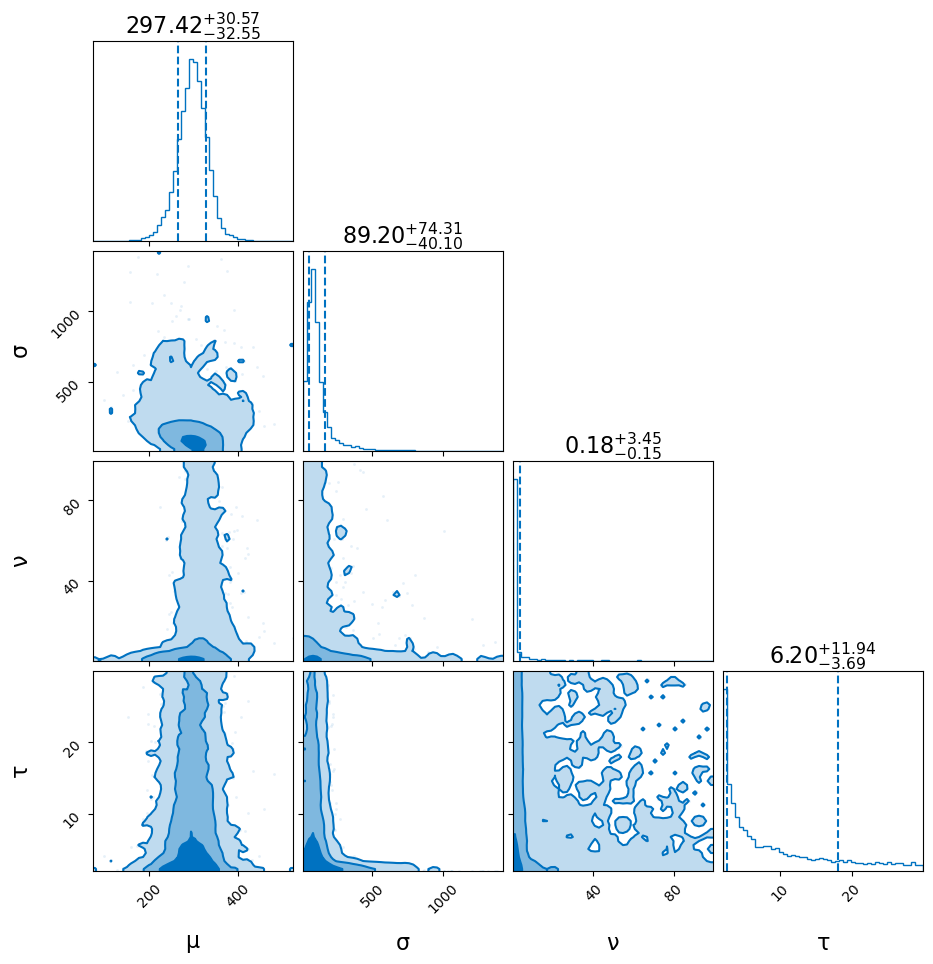

In [17]:
#begin SST
from scipy.special import beta
def hyper_prior_sst(dataset, mu,sigma,nu,tau):
        c = 2 * nu * ((1 + nu ** 2) *
                                beta(0.5, tau / 2) *
                                tau ** 0.5) ** -1
        m = ((2 * tau ** 0.5) * (nu - nu ** -1)) / (
                (tau - 1) * beta(0.5, 0.5 * tau))
        s2 = ((tau / (tau - 2)) * (
                nu ** 2 + nu ** -2 - 1) - m ** 2)
        mu_0 = mu - (sigma * m / np.sqrt(s2))
        sigma_0 = sigma / np.sqrt(s2)
        z = (dataset['mu'] - mu_0) / sigma_0
        p = np.where(dataset['mu'] < mu_0,
                     (c / sigma_0) * (1 + ((nu ** 2) * (z ** 2)) / tau) ** (
                             -(tau + 1) / 2),
                     (c / sigma_0) * (1 + (z ** 2) / ((nu ** 2) * tau)) ** (
                             -(tau + 1) / 2))
        return p

hp_priors_sst = dict(mu=Uniform(10, 4000, 'mlo',r'$\rm{\mu}$'),
                sigma=Uniform(10, 1500, 'sigma',r'$\rm{\sigma}$'),
                nu=LogUniform(0.01,100,'nu',r'$\rm{\nu}$'),
                tau=LogUniform(2.01,30,'tau',r'$\rm{\tau}$') )
#end SST

hyper_prior_sst=hyper_prior_sst
hp_likelihood_sst = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_sst,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_sst =hp_priors_sst

# And run sampler
result_sst = run_sampler(
    likelihood=hp_likelihood_sst, priors=hp_priors_sst, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_sst.plot_corner()

15:51 bilby INFO    : Running for label 'exponential_hype_59454', output will be saved to 'hy_outdir'
15:51 bilby INFO    : Analysis priors:
15:51 bilby INFO    : lam=LogUniform(minimum=0.0001, maximum=0.01, name='lam', latex_label='$\\lambda$', unit=None, boundary=None)
15:51 bilby INFO    : mlo=Uniform(minimum=1, maximum=400, name='mlo', latex_label='$\\rm{v^l}$', unit=None, boundary=None)
15:51 bilby INFO    : mup=Uniform(minimum=400, maximum=10000, name='mup', latex_label='$\\rm{v^u}$', unit=None, boundary=None)
15:51 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
15:51 bilby INFO    : Analysis likelihood noise evidence: 0
15:51 bilby INFO    : Single likelihood evaluation took 3.604e-04 s
15:51 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 2000, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'rstate': None, 'queue_size': 300, 'pool': None,

1it [00:00, ?it/s]

/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in

15:52 bilby INFO    : Rejection sampling nested samples to obtain 4663 posterior samples
15:52 bilby INFO    : Sampling time: 0:00:27.474545
15:52 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
15:52 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
15:52 bilby INFO    : Summary of results:
nsamples: 4663
ln_noise_evidence:  0.000
ln_evidence: -126.169 +/-  0.050
ln_bayes_factor: -126.169 +/-  0.050



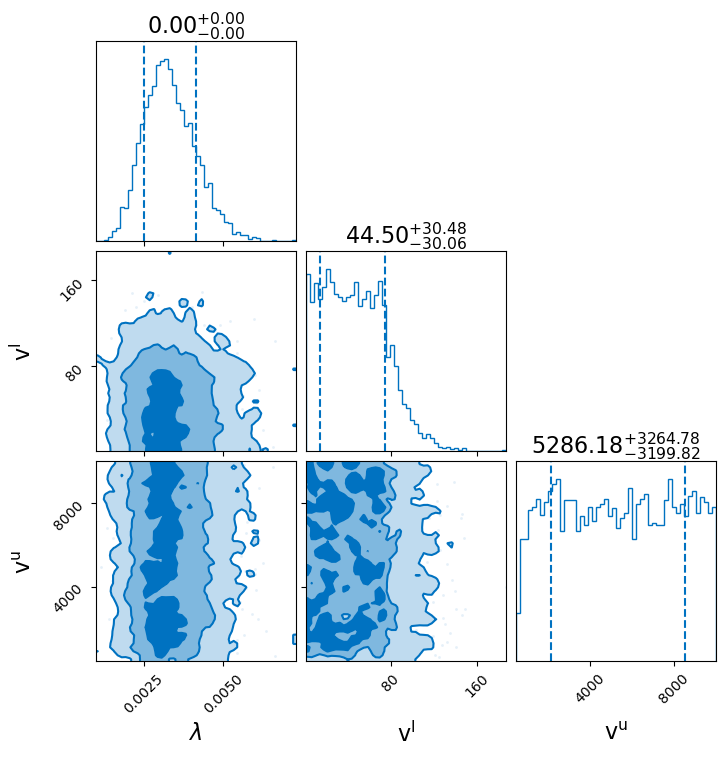

In [18]:
from scipy.stats import expon

def hyper_prior_exponential(dataset, mup, mlo, lam):
    valid_range = (dataset['mu'] >= mlo) & (dataset['mu'] <= mup)
    # Exponential PDF
    pdf_values = expon.pdf(dataset['mu'], scale=1/lam)
    # 限制范围外的概率为 0
    log_likelihood = valid_range * pdf_values
    return log_likelihood

hp_priors_exponential = dict(
    lam=LogUniform(0.0001, 0.01, 'lam', r'$\lambda$'),  # 速率参数范围
    mlo=Uniform(1, 400, 'mlo', r'$\rm{v^l}$'),  # 下限范围
    mup=Uniform(400, 10000, 'mup', r'$\rm{v^u}$')    # 上限范围
)

hyper_prior_exponential = hyper_prior_exponential

hp_likelihood_exponential = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_exponential,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_exponential = hp_priors_exponential

# 运行采样器
result_exponential = run_sampler(
    likelihood=hp_likelihood_exponential, priors=hp_priors_exponential, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='exponential_hype_{}'.format(np.random.randint(1, 88888)),
    verbose=True, clean=True, npool=npool)

# 绘制角图
result_exponential.plot_corner()

In [1]:
import bilby
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
file_exponential='/home/lz/work/pulsar_kick_velocity/hy_outdir/exponential_hype_59454_result.json'
result_exponential = bilby.result.read_in_result(file_exponential)
posterior_exponential=result_exponential.posterior
print(posterior_exponential)

           lam         mlo          mup  log_likelihood  log_prior
0     0.000977   89.609407   923.071854     -132.327217  -9.754194
1     0.003263  187.043062  3988.808039     -130.847549 -10.960542
2     0.001148   85.530310  4920.798340     -129.913978  -9.915605
3     0.005982  124.271581  6692.355395     -129.598581 -11.566589
4     0.006642  103.951248   686.332775     -129.536755 -11.671295
...        ...         ...          ...             ...        ...
4658  0.003323    3.865628  4345.931137     -122.596891 -10.978890
4659  0.003317   11.090154  6402.406213     -122.596889 -10.976845
4660  0.003318   17.745664  7637.092032     -122.596885 -10.977173
4661  0.003321   18.354169  7546.295905     -122.596883 -10.978198
4662  0.003321    6.030980  5876.375726     -122.596882 -10.978059

[4663 rows x 5 columns]


1σ 中心区间: (0.0025, 0.004132)
0.003231214533249786


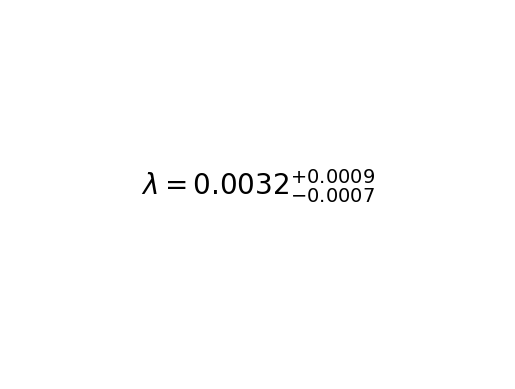

In [2]:

# 计算中心区间
center_interval = np.percentile(posterior_exponential['lam'], [16, 84])
print(f"1σ 中心区间: ({center_interval[0]:.4f}, {center_interval[1]:.4})")
median_lam=np.median(posterior_exponential['lam'])
print(median_lam)
alpha = center_interval[1] - median_lam
beta = median_lam - center_interval[0]

latex_str = f"$\\lambda = {median_lam:.4f} ^{{+{alpha:.4f}}} _{{-{beta:.4f}}}$"
# 显示LaTeX公式
plt.text(0.5, 0.5, latex_str, fontsize=20, ha='center')
plt.axis('off')  # 关闭坐标轴
plt.show()

In [4]:
print(bayes_factors)

[np.float64(1.5511552873877033), np.float64(0.29258501645355695), np.float64(1.343126358686279), np.float64(0.82448197413911), np.float64(0.11429185163558886), np.float64(0.8361058993970338), np.float64(0.0005319292852074498), np.float64(0.6790910949266364)]


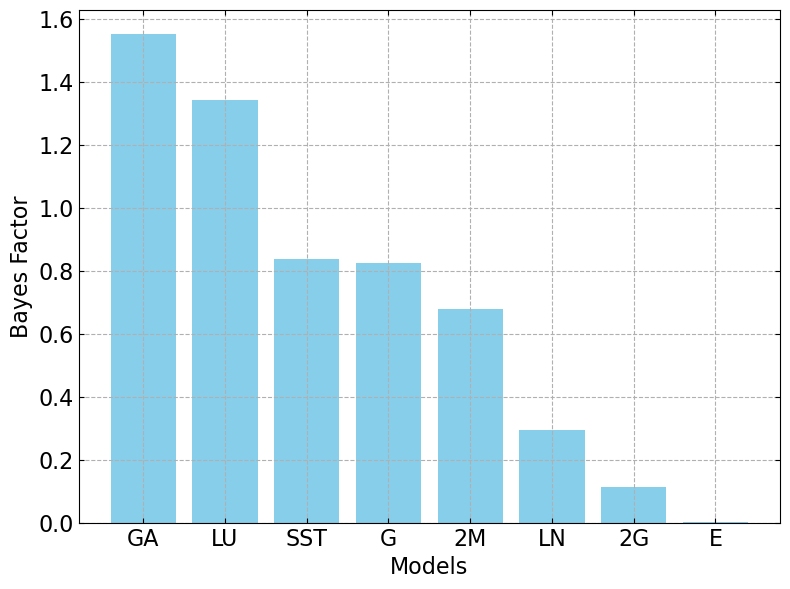

In [3]:
import numpy as np
from matplotlib import pyplot as plt
BF_gamma_maxwell=-118.191+118.630
BF_lognormal_maxwell=-119.859 +118.630
BF_loguniform_maxwell=-118.335+118.630
BF_gaussian_maxwell=-118.823+118.630
BF_double_gaussian_maxwell=-120.799+118.630
#BF_power_exponential=-158.387+161.920
BF_sst_maxwell=-118.809+118.630
BF_exponential_maxwell=-126.169+118.630
BF_double_maxwell_maxwell=-119.017+118.630
#------------------exp of BF----------------------
BF_gamma_maxwell_exp=np.exp(BF_gamma_maxwell)
BF_lognormal_maxwell_exp=np.exp(BF_lognormal_maxwell)
BF_loguniform_maxwell_exp=np.exp(BF_loguniform_maxwell)
BF_gaussian_maxwell_exp=np.exp(BF_gaussian_maxwell)
BF_double_gaussian_maxwell_exp=np.exp(BF_double_gaussian_maxwell)
#BF_power_exponential_exp=np.exp(BF_power_exponential)
BF_sst_maxwell_exp=np.exp(BF_sst_maxwell)
BF_exponential_maxwell_exp=np.exp(BF_exponential_maxwell)
BF_double_maxwell_maxwell_exp=np.exp(BF_double_maxwell_maxwell)
#-------------------------------------------------
from matplotlib.ticker import MultipleLocator,FuncFormatter
# Simplified labels for models
models = ["GA", "LN", "LU", "G", "2G", "SST","E","2M"]
'''
bayes_factors=[BF_gamma_exponential, BF_lognormal_exponential,BF_loguniform_exponential,
               BF_gaussian_exponential,BF_double_gaussian_exponential,
'''
bayes_factors=[BF_gamma_maxwell_exp, BF_lognormal_maxwell_exp,BF_loguniform_maxwell_exp,
               BF_gaussian_maxwell_exp,BF_double_gaussian_maxwell_exp,
               BF_sst_maxwell_exp,BF_exponential_maxwell_exp,BF_double_maxwell_maxwell_exp]
# 从大到小排序  
sorted_indices = np.argsort(bayes_factors)[::-1]
sorted_models = [models[i] for i in sorted_indices]
sorted_bayes_factors = [bayes_factors[i] for i in sorted_indices]

# 绘制柱状图
fig,ax=plt.subplots(figsize=(8,6))
#ax.set_xticks([-2,-1,0,1])
#ax.set_yticks([10**4,1.5*10**4,2*10**4,2.5*10**4])
plt.tick_params(top='on', right='on', which='both')
#ax.xaxis.set_minor_locator(MultipleLocator(0.1))
#ax.yaxis.set_minor_locator(MultipleLocator(10000))
ax.tick_params(axis='both',which='both',direction='in',labelsize=16)
plt.bar(sorted_models, sorted_bayes_factors, color='skyblue',log=False)

plt.ylabel("Bayes Factor", fontsize=16)
plt.xlabel("Models", fontsize=16)
#plt.title("Bayes Factors Comparison", fontsize=14)
#plt.yscale('log')
plt.tight_layout()
#plt.yscale('log')
plt.grid(linestyle='--')
plt.savefig('Bayes_factors_comparison.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()